# Homework 4: More Principal Component Analysis
***
This homework focuses on familiarizing you with low-rank approximations and multi-dimensional scaling. In addition, you will work with the CIFAR-10 dataset, a popular benchmark dataset for most classification algorithms.

# Load data

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from scipy import linalg
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
data_batch1 = unpickle('data/data_batch_1')
data_batch2 = unpickle('data/data_batch_2')
data_batch3 = unpickle('data/data_batch_3')
data_batch4 = unpickle('data/data_batch_4')
data_batch5 = unpickle('data/data_batch_5')

test_batch = unpickle('data/test_batch')

In [4]:
combined_data = np.concatenate((data_batch1[b'data'], data_batch2[b'data'], data_batch3[b'data'], data_batch4[b'data'], data_batch5[b'data'], test_batch[b'data']))
combined_labels = np.concatenate((data_batch1[b'labels'], data_batch2[b'labels'], data_batch3[b'labels'], data_batch4[b'labels'], data_batch5[b'labels'], test_batch[b'labels']))
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Part A

In [5]:
def getPCA(data, n_components):
    pca = PCA(n_components)
    pca.fit(data)
    return pca

In [6]:
def aggregateByCategory(data, labels): 
    imageByCategory = {}
    for index in range(len(data)):
        label = labels[index]
        if(label not in imageByCategory):
            imageByCategory[label] = []
        imageByCategory[label].append(data[index])
    return imageByCategory

In [7]:
def getPCAForImages(images):
    categoryPCA = {}
    for category in imagesByCategory:
        images = np.array(imagesByCategory[category])
        categoryPCA[category] = getPCA(images, 20)
    return categoryPCA

In [8]:
def showImage(pixels, label):
    pixels = np.reshape(pixels,(3,1024))
    pixels = np.transpose(pixels)
    pixels = np.reshape(pixels,(32,32,3))
    pixels.astype('uint8')
    plt.title(label)
    plt.imshow(pixels)
    plt.show()

In [9]:
mean_images = np.zeros((10, 3072))

for i in range(0, 60000):
    mean_images[combined_labels[i]] = mean_images[combined_labels[i]] + combined_data[i]

mean_images = mean_images / 6000
mean_images = mean_images.astype('uint8')  

## Show mean images by class

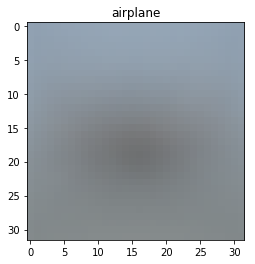

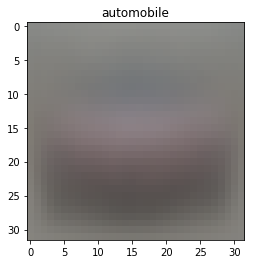

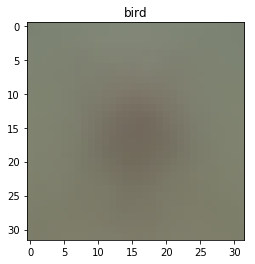

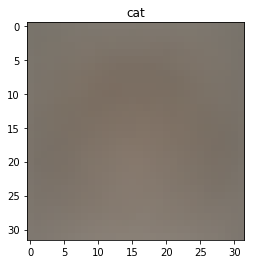

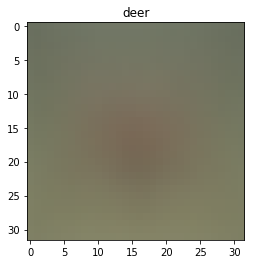

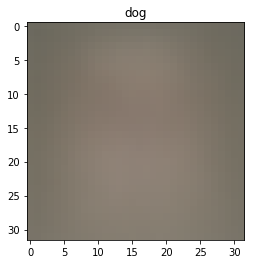

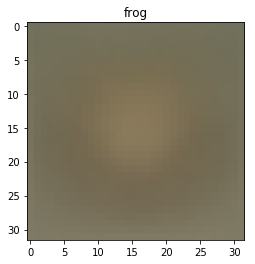

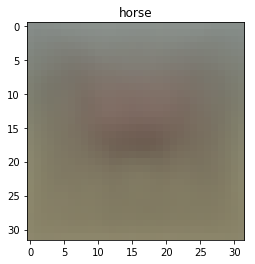

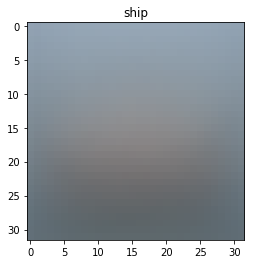

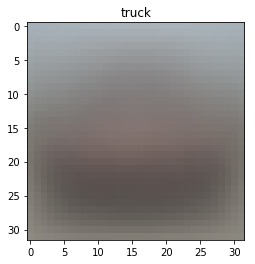

In [10]:
for i in range(0, 10):
    showImage(mean_images[i], label_names[i])

## PCA first 20 principal components

In [11]:
imagesByCategory = aggregateByCategory(combined_data, combined_labels)

In [12]:
pcaByImageCategory = getPCAForImages(imagesByCategory)

## Compute a low-dimensional reconstruction of each image in the class

In [13]:
imagesByCategoryReconstructed = np.zeros(184320000).reshape(10, 6000, 3072)

In [14]:
for cat in imagesByCategory:
        imagesByCategoryReconstructed[cat] = pcaByImageCategory[cat].inverse_transform(pcaByImageCategory[cat].transform(imagesByCategory[cat]))

## For each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels.

In [15]:
sq_diff = np.zeros(10)

for i in range(0, 10):
    sq_diff[i] = (np.linalg.norm(imagesByCategory[i]-imagesByCategoryReconstructed[i])**2)/6000
    print ("Average of sums of squared difference for class", i, ":", sq_diff[i])

Average of sums of squared difference for class 0 : 2620530.77145
Average of sums of squared difference for class 1 : 3950698.86702
Average of sums of squared difference for class 2 : 2447704.14209
Average of sums of squared difference for class 3 : 3116490.44879
Average of sums of squared difference for class 4 : 2180404.08164
Average of sums of squared difference for class 5 : 3231141.85955
Average of sums of squared difference for class 6 : 2630246.89013
Average of sums of squared difference for class 7 : 3441107.47444
Average of sums of squared difference for class 8 : 2440646.60472
Average of sums of squared difference for class 9 : 4021116.43057


## Bar graph showing the squared difference for each class

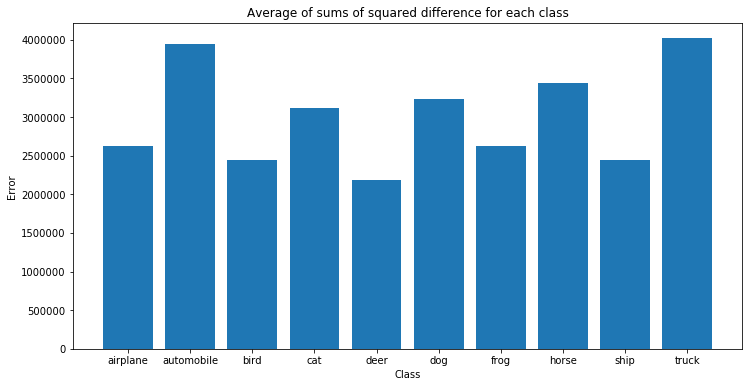

In [22]:
from matplotlib.pyplot import figure
figure(figsize=(12, 6))

y_pos = np.arange(len(label_names))
plt.bar(y_pos, sq_diff, align='center')
plt.xticks(y_pos, label_names)
plt.ylabel('Error')
plt.xlabel('Class')
plt.title('Average of sums of squared difference for each class')
plt.show()

# Part B

In [23]:
def calculateDistance(mean_images):
    distance = np.zeros((10,10))
    length = len(mean_images)
    
    for i in range(length):
        for j in range(length):
            a = mean_images[i].reshape(1,-1)
            b = mean_images[j].reshape(1,-1)
            distance[i,j] = np.square(euclidean_distances(a, b))
    return distance

In [24]:
def calculateMDS(distance_matrix):
    length = len(mean_images)
    A = np.identity(length)-1/length*np.ones((length,length))
    W = np.matmul(np.square(-1/2 * np.matmul(A, distance_matrix)), A.T)
    eigenvalue, eigenvector = linalg.eig(W)
    idx = eigenvalue.argsort()[::-1]
    eigenvalue = eigenvalue[idx]
    eigenvector = eigenvector[:,idx]
    top_s = eigenvector[:,:2]
    block_s = [[np.sqrt(eigenvalue[0]),0],[0,np.sqrt(eigenvalue[1])]]
    Y = np.matmul(top_s, block_s)
    return Y

In [25]:
distance_matrix = calculateDistance(mean_images)

In [26]:
mds = calculateMDS(distance_matrix)

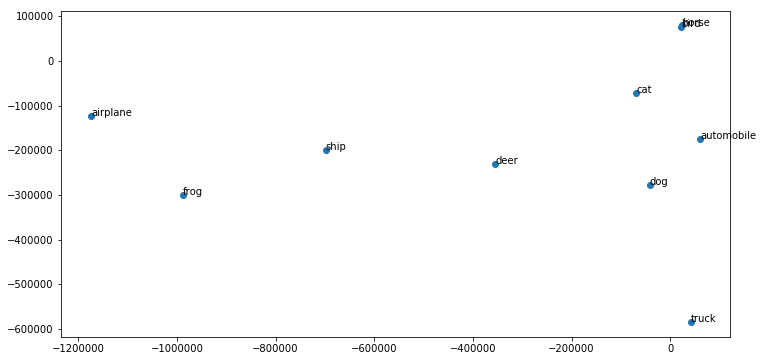

In [27]:
figure(figsize=(12, 6))

for i, txt in enumerate(label_names):
    plt.annotate(txt, (np.real(mds[i, 0]), np.real(mds[i, 1])))
    
plt.scatter(np.real(mds[:,0]), np.real(mds[:,1]))
plt.show()

# Part C